# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. Complete the required functions in `hw4.py` script only. This exercise is graded automatically, and only the `hw4.py` script is tested.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/), numpy and pandas only. **Do not import anything else.**
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes this notebook with the exercise number and your ID as the filename and the `hw4.py` script. For example: `hw4_123456789_987654321.ipynb` and `hw4.py` if you submitted in pairs and `hw4_123456789.ipynb` and `hw4.py` if you submitted the exercise alone.

# I have read and understood the instructions: 

In [328]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
# Function for ploting the decision boundaries of a model
def plot_decision_regions(X, y, classifier, resolution=0.01, title=""):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.title(title)
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    plt.show()

## Feature selection (10 points)


In [330]:
dataset = pd.read_csv('data.csv')

In [331]:
dataset.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,0,98074,47.6168,-122.045,1800,7503


In [332]:
X = dataset.drop('price', axis=1)
y = dataset['price']

FeatureSelection class should contain the following functions:
1. pearson_correlation - calculate pearson correlation for two given arrays.
2. feature_selection - select the best n features.


Our task is to select the best features using Pearson correlation. Implement the Pearson correlation as follows:
$$
r(x,y) = \frac{\sum_{d=1}^m (x_d - \mu_x)(y_d - \mu_y)}{\sqrt{\sum_{d=1}^m (x_d - \mu_x)^2\sum_{d=1}^n (y_d - \mu_y})^2}
$$

In [333]:
from hw4 import feature_selection

In [334]:
# test FeatureSelection on the data
X["date"] = pd.to_numeric(pd.to_datetime(X["date"]))
feature_selection(X, y)

['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']

## Reading the data

In [335]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

In [336]:
def visualize_data(X, y, title_prefix=""):
    if title_prefix is None or title_prefix == "":
        title_prefix = ""
    else:
        title_prefix = f"{title_prefix} - "

    # prepare data
    classes = np.unique(y_training)
    X_1000 = X[:1000, :]
    y_1000 = y[:1000]

    # hist for first feature - first 1000 data points:
    plt.figure(figsize=(8, 5))

    for i in range(len(classes)):
        data = X_1000[y_1000 == classes[i]][:, 0]
        plt.hist(data, bins=20, alpha=0.5, label=['class={}'.format(i)])  # `density=False` would make counts

    plt.xlabel('x1 feature')
    plt.ylabel('Amount')
    plt.title(f'{title_prefix}histogram of first 1000 data points of each class')
    plt.grid()
    plt.legend()
    plt.show()

    # hist for first feature - all data points:
    plt.figure(figsize=(8, 5))

    for i in range(len(classes)):
        data = X[y == classes[i]][:, 0]
        plt.hist(data, bins=20, alpha=0.5, label=['class={}'.format(i)])  # `density=False` would make counts

    plt.xlabel('x1 feature')
    plt.ylabel('Amount')
    plt.title(f'{title_prefix}histogram of all data points of each class')
    plt.grid()
    plt.legend()
    plt.show()

    # scatter for both features - first 1000 data points:
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        data = X_1000[y_1000 == classes[i]]
        plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

    plt.title(f'{title_prefix}scatter plot for first 1000 data points of each class')
    plt.legend()
    plt.xlabel('x1 feature units')
    plt.ylabel('x2 feature units')
    plt.grid()
    plt.show()

    # scatter for both features - all data points:
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        data = X[y == classes[i]]
        plt.scatter(data[:, 0], data[:, 1], label='class={}'.format(i))

    plt.title(f'{title_prefix}scatter plot for all data points of each class')
    plt.legend()
    plt.xlabel('x1 feature units')
    plt.ylabel('x2 feature units')
    plt.grid()
    plt.legend()
    plt.show()


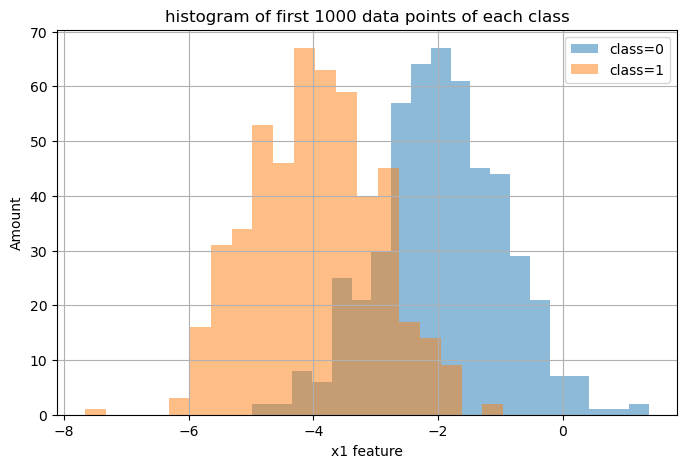

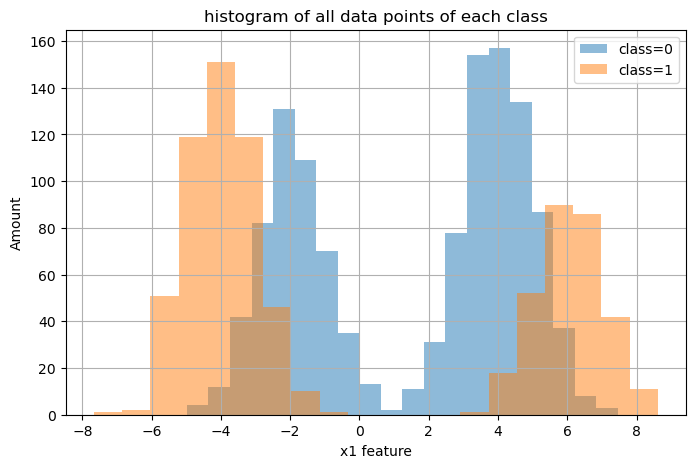

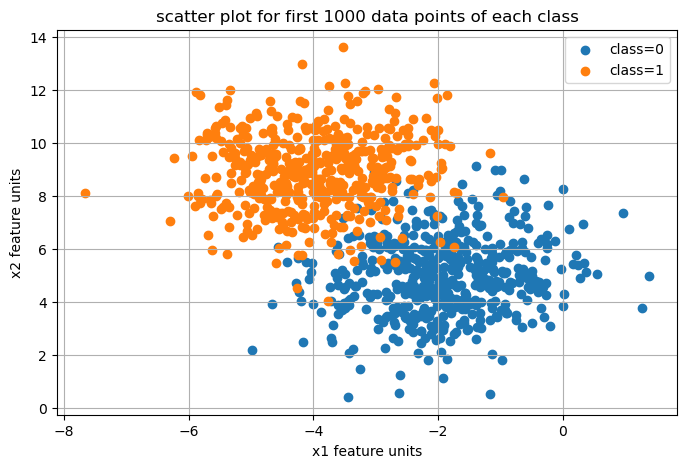

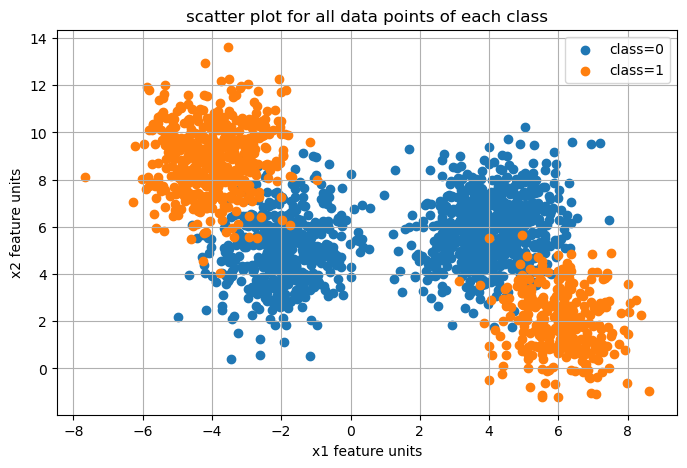

In [337]:
visualize_data(X_training, y_training)

## Logistic Regression (15 points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed
Your model should also store a list of the costs that you've calculated in each iteration

Open `hw4.py` and implement the `LogisticRegressionGD` class.

Note the following:
1. The `fit` method should train the model given the training data.
1. The `predict` method should provide predictions for given instances.
1. You can add as many auxiliary functions as you need. Only the above two functions will be tested.

In [338]:
from hw4 import LogisticRegressionGD

In [339]:
# test lor class on all the data
lor = LogisticRegressionGD()
lor.fit(X_training, y_training)

predictions_x_train = lor.predict(X_training)
predictions_x_test = lor.predict(X_test)

## Cross Validation (10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Open `hw4.py` and implement the function `cross_validation`.

Note the following:
1. This function should not change the original data.
1. You should shuffle the data before splitting in order to get correct results.
1. You should return the average accuracy for each fold in order to compare models with different hyper-parameters.

Shuffle the training set before you split the data to the folds.

In [340]:
from hw4 import cross_validation

In [341]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
folds = 5

random_state = 1
acc_dict = {}
for eta in etas:
    for eps in epss:
        lor = LogisticRegressionGD(eta=eta, eps=eps, random_state=random_state)
        acc = cross_validation(X_training, y_training, folds, lor, random_state=random_state)
        acc_dict[(eta, eps)] = acc
        print(f"Accuracy with eta={eta}, eps={eps}:  {acc:.6f}")

best_params = max(acc_dict, key=acc_dict.get)
best_eta = best_params[0]
best_eps = best_params[1]

Accuracy with eta=0.05, eps=0.01:  0.598500
Accuracy with eta=0.05, eps=0.001:  0.598500
Accuracy with eta=0.05, eps=0.0001:  0.598500
Accuracy with eta=0.05, eps=1e-05:  0.598500
Accuracy with eta=0.05, eps=1e-06:  0.598500
Accuracy with eta=0.005, eps=0.01:  0.603000
Accuracy with eta=0.005, eps=0.001:  0.603000
Accuracy with eta=0.005, eps=0.0001:  0.603000
Accuracy with eta=0.005, eps=1e-05:  0.603000
Accuracy with eta=0.005, eps=1e-06:  0.603000
Accuracy with eta=0.0005, eps=0.01:  0.598500
Accuracy with eta=0.0005, eps=0.001:  0.598500
Accuracy with eta=0.0005, eps=0.0001:  0.598500
Accuracy with eta=0.0005, eps=1e-05:  0.598500
Accuracy with eta=0.0005, eps=1e-06:  0.598500
Accuracy with eta=5e-05, eps=0.01:  0.529000
Accuracy with eta=5e-05, eps=0.001:  0.562500
Accuracy with eta=5e-05, eps=0.0001:  0.572000
Accuracy with eta=5e-05, eps=1e-05:  0.690500
Accuracy with eta=5e-05, eps=1e-06:  0.800500
Accuracy with eta=5e-06, eps=0.01:  0.401500
Accuracy with eta=5e-06, eps=0.001:

In [342]:
print(f"Best learning rate (eta): {best_eta}")
print(f"Best epsilon: {best_eps}")

best_acc = acc_dict[best_params]
print(f"Accuracy with the best parameters: {best_acc:.4f}")

Best learning rate (eta): 5e-05
Best epsilon: 1e-06
Accuracy with the best parameters: 0.8005


### Normal distribution pdf (5 points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Open `hw4.py` and implement the function `norm_pdf`.

It might be a good idea to test your implementation in the next cell before you continue.

In [343]:
from hw4 import norm_pdf

## your tests here ##

## Expectation Maximization (15 points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

Open `hw4.py` and implement the class `EM`.

In [344]:
from hw4 import EM

In [345]:
em_obj = EM(k=2)
em_obj.fit(X_training[:, 0].reshape(-1, 1))

print(f"mus = {em_obj.get_dist_params()[1]}")
print(f"sigmas = {em_obj.get_dist_params()[2]}")
print(f"weights = {em_obj.get_dist_params()[0]}")

mus = [ 4.64035659 -2.96313096]
sigmas = [1.37575767 1.42141258]
weights = [0.50078852 0.49921148]


### GMM (5 points)

Open `hw4.py` and implement the function `gmm_pdf`.

It might be a good idea to test your implementation in the next cell before you continue.

In [346]:
from hw4 import gmm_pdf

## your tests here ##

## Naive Bayes (15 points)

Implement the Naive Bayes algorithm.

Calculate the likelihood using the EM algorithm you implemented above and find the distribution parameters. With these parameters you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Note the following:
1. The `fit` method should train the model given the training data.
1. The `predict` method should provide predictions for given instances.
1. You can add as many auxiliary functions as you need. Only the above two functions will be tested.

In [373]:
from hw4 import NaiveBayesGaussian

In [374]:
# test Naive Bayes
naive_byes = NaiveBayesGaussian(k=2)
naive_byes.fit(X_training, y_training)
predictions_x_train = naive_byes.predict(X_training)
predictions_x_test = naive_byes.predict(X_test)
train_acc = np.count_nonzero(predictions_x_train == y_training.reshape(-1, 1)) / len(y_training)
test_acc = np.count_nonzero(predictions_x_test == y_test.reshape(-1, 1)) / len(y_test)
print(f"Naive byes training set accuracy: {train_acc:.4f}")
print(f"Naive byes test set accuracy: {test_acc:.4f}")

Naive byes training set accuracy: 1200.0000
Naive byes test set accuracy: 600.0000


## Model evaluation (15 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

In [378]:
from hw4 import model_evaluation

In [379]:
# Train - 1000, Test - 500
X_training_1000 = X_training[:1000, :]
y_training_1000 = y_training[:1000]

X_test_500 = X_test[:500, :]
y_test_500 = y_test[:500]

model_evaluation(X_training_1000, y_training_1000, X_test_500, y_test_500, 1, best_eta, best_eps)

{'lor_train_acc': 0.965,
 'lor_test_acc': 0.938,
 'bayes_train_acc': 0.5,
 'bayes_test_acc': 0.5}

In [380]:
# Full Data
model_evaluation(X_training, y_training, X_test, y_test, 2, best_eta, best_eps)

{'lor_train_acc': 0.809,
 'lor_test_acc': 0.804,
 'bayes_train_acc': 0.6,
 'bayes_test_acc': 0.6}

## Open question (15 points)
1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset (`dataset_a`), in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) such that **Naive Bayes will work better on it when compared to Logisitc Regression**.
   2. Generate another dataset (`dataset_b`), in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) such that **Logistic Regression will work better on it when compared to Naive Bayes**.
   
2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

In [387]:
from hw4 import generate_datasets

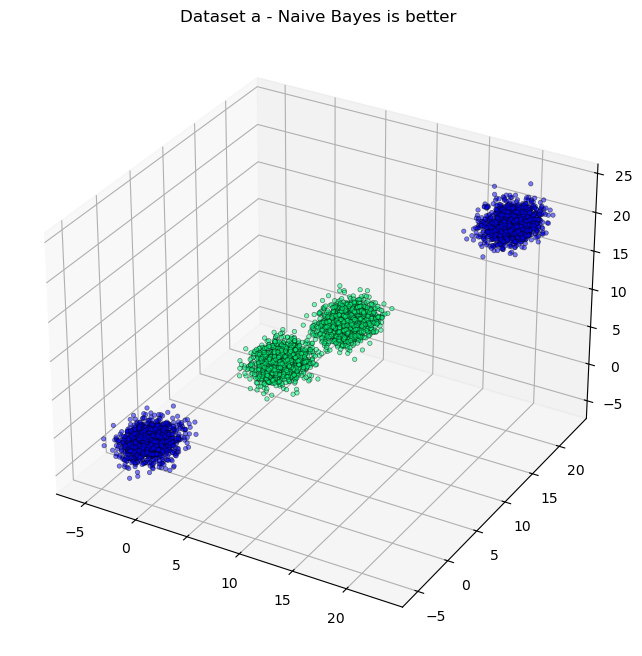

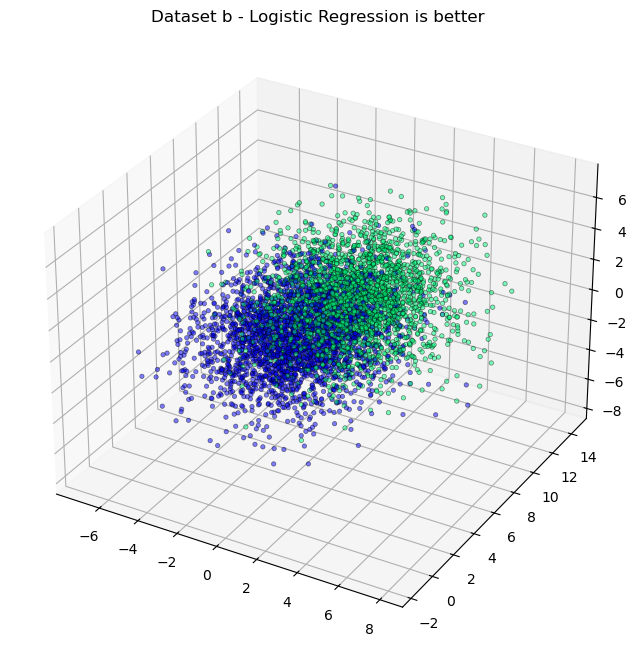

{'dataset_a_features': array([[ 0.09472193, -3.47325046, -0.5906299 ],
        [-1.69788248, -1.42690674, -1.30512967],
        [-3.51519447, -2.2673982 , -2.36227968],
        ...,
        [19.72490949, 18.91044098, 20.62035947],
        [17.770961  , 21.87153821, 20.47713811],
        [22.13380431, 20.17158119, 19.60122935]]),
 'dataset_a_labels': array([0., 0., 0., ..., 0., 0., 0.]),
 'dataset_b_features': array([[ 1.08654053,  5.27219905,  0.37868906],
        [-2.112541  ,  3.62958761, -3.10957322],
        [-2.89771346,  4.68542072, -1.04799548],
        ...,
        [ 0.73687723,  7.35583937, -0.5411916 ],
        [ 1.30134633,  5.14568401,  1.78041828],
        [ 0.6348146 ,  6.70765086,  1.54332364]]),
 'dataset_b_labels': array([0., 0., 0., ..., 1., 1., 1.])}

In [388]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Generate the datasets
datasets = generate_datasets()

def plot_data(features, labels, title):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='winter', s=10, alpha=0.5,
                   edgecolors='black', linewidths=0.5)
        ax.set_title(title)
        plt.show()

# Plot Dataset 1
plot_data(datasets['dataset_a_features'], datasets['dataset_a_labels'], "Dataset a - Naive Bayes is better")

# Plot Dataset 2
plot_data(datasets['dataset_b_features'], datasets['dataset_b_labels'], "Dataset b - Logistic Regression is better")

# Return the dataset values
datasets